In [2]:
import pandas as pd
import os
from lockdown import LockDown
import csv
import matplotlib.pyplot as plt
import statistics
from numpy import log

In [3]:
all_data = []
dtype = {
    "country_region_code":str,
    "country_region":str,
    "sub_region_1":str,
    "sub_region_2":str,
    "metro_area":str,
    "iso_3166_2_code":str,
    "census_fips_code":str,
    "place_id":str,
    "date":object,
    "retail_and_recreation_percent_change_from_baseline":float,
    "grocery_and_pharmacy_percent_change_from_baseline":float,
    "parks_percent_change_from_baseline":float,
    "transit_stations_percent_change_from_baseline":float,
    "workplaces_percent_change_from_baseline":float,
    "residential_percent_change_from_baseline":float
}
deleted_countries = [
    "LV",#Letonya
    "LU",#Lüksemburg
    "MT",#Malta
    "SI",#Slovenya
    "SE",#İsveç
]

dropped_columns = [
    'sub_region_1',
    'sub_region_2',
    'metro_area',
    'iso_3166_2_code',
    'census_fips_code',
    'place_id',
]

new_column_names = {
    'retail_and_recreation_percent_change_from_baseline': 'retail_and_recreation',
    'grocery_and_pharmacy_percent_change_from_baseline': 'grocery_and_pharmacy',
    'parks_percent_change_from_baseline': 'parks',
    'transit_stations_percent_change_from_baseline': 'transit_stations',
    'workplaces_percent_change_from_baseline': 'workplaces',
    'residential_percent_change_from_baseline': 'residential',
}

retail_and_recreation_factor = -0.25
grocery_and_pharmacy_factor = -0.05
parks_factor = -0.1
transit_stations_factor = -0.1
workplaces_factor = -0.2
residential_factor = 0.3

lockdowns_data = [
    ['AT', '16.03.2020', '13.04.2020'],
    ['AT', '03.11.2020', '30.11.2020'],
    ['AT', '26.12.2020', '07.02.2021'],
    ['AT', '22.11.2021', '12.12.2021'],
    ['BE', '18.03.2020', '04.05.2020'],
    ['BE', '02.11.2020', '14.12.2020'],
    ['BE', '27.03.2021', '26.04.2021'],
    ['BG', '13.03.2020', '15.06.2020'],
    ['BG', '28.11.2020', '31.01.2021'],
    ['BG', '22.03.2021', '31.03.2021'],
    ['HR', '18.03.2020', '11.05.2020'],
    ['HR', '22.12.2020', '29.12.2020'],
    ['CZ', '16.03.2020', '12.04.2020'],
    ['CZ', '22.10.2020', '28.03.2021'],
    ['DK', '12.03.2020', '13.04.2020'],
    ['DK', '25.12.2020', '01.03.2021'],
    ['FR', '17.03.2020', '11.05.2020'],
    ['FR', '30.10.2020', '15.12.2020'],
    ['FR', '04.04.2021', '03.05.2021'],
    ['FI', '16.03.2020', '13.05.2020'],
    ['FI', '08.03.2021', '28.03.2021'],
    ['EE', '11.03.2021', '11.04.2021'],
    ['DE', '16.03.2020', '30.05.2020'],
    ['DE', '02.11.2020', '01.03.2021'],
    ['GR', '23.03.2020', '04.05.2020'],
    ['GR', '07.11.2020', '22.03.2021'],
    ['HU', '28.03.2020', '10.04.2020'],
    ['IE', '12.03.2020', '18.05.2020'],
    ['IE', '21.10.2020', '01.12.2020'],
    ['IE', '24.12.2020', '12.04.2021'],
    ['IT', '09.03.2020', '12.04.2021'],
    ['IT', '24.12.2020', '06.01.2021'],
    ['IT', '15.03.2021', '30.04.2021'],
    ['LT', '16.03.2020', '18.06.2020'],
    ['LT', '07.11.2020', '01.07.2021'],
    ['NL', '15.03.2020', '06.04.2020'],
    ['NL', '15.12.2020', '05.06.2021'],
    ['NL', '13.11.2021', '12.12.2021'],
    ['PL', '13.03.2020', '11.04.2020'],
    ['PL', '28.12.2020', '17.01.2021'],
    ['PL', '20.03.2021', '25.04.2021'],
    ['PT', '19.03.2020', '02.04.2020'],
    ['PT', '15.01.2021', '15.03.2021'],
    ['RO', '25.03.2020', '12.05.2020'],
    ['SK', '25.11.2021', '09.12.2021'],
    ['ES', '14.03.2020', '09.05.2020'],
]

columns_will_get_from_who_data = ['New_cases', 'New_deaths']

files = os.listdir("assets")
countries = [x for x in files if x[5:7] not in deleted_countries]  # deleted unnecessary countries

def sort_func(string):
    return string[5:7] + string[:5]

countries = sorted(countries, key=sort_func)

who_data = pd.read_csv("WHO-COVID-19-global-data.csv")
who_data['date'] = pd.to_datetime(who_data['Date_reported'])

In [4]:
for csv_file in countries:
    file_name = csv_file.split(".")[0]
    data_frame = pd.read_csv(
        "assets/{filename}".format(filename=csv_file),
        dtype=dtype
    )
    all_data.append(data_frame)

In [5]:
summed_datas = []
for x1, x2 in zip(all_data[::2], all_data[1::2]):
    summed_data = pd.concat([x1, x2])
    summed_datas.append(summed_data)

In [6]:
clean_all_data = []
for df in summed_datas:
    cleaned_data = df[df['sub_region_1'].isnull()]
    clean_all_data.append(cleaned_data)

In [7]:
summed_data_frame = pd.concat(clean_all_data, ignore_index=True)
summed_data_frame['date'] = pd.to_datetime(summed_data_frame['date'])
summed_data_frame.drop(columns=dropped_columns, inplace=True)
summed_data_frame.rename(columns=new_column_names, inplace=True)

lockdowns = [ LockDown(x, y, z) for x,y,z in lockdowns_data]
for x in lockdowns:
    x.set_data(summed_data_frame, who_data, columns_will_get_from_who_data)

In [8]:
summed_data_frame.to_csv("data.csv")

In [9]:
max_retail_and_recreation = summed_data_frame['retail_and_recreation'].max()
max_grocery_and_pharmacy = summed_data_frame['grocery_and_pharmacy'].max()
max_parks = summed_data_frame['parks'].max()
max_transit_stations = summed_data_frame['transit_stations'].max()
max_workplaces = summed_data_frame['workplaces'].max()
max_residential = summed_data_frame['residential'].max()

In [10]:
min_retail_and_recreation = summed_data_frame['retail_and_recreation'].min()
min_grocery_and_pharmacy = summed_data_frame['grocery_and_pharmacy'].min()
min_parks = summed_data_frame['parks'].min()
min_transit_stations = summed_data_frame['transit_stations'].min()
min_workplaces = summed_data_frame['workplaces'].min()
min_residential = summed_data_frame['residential'].min()

In [11]:
for lockdown in lockdowns:
    avg_values = lockdown.get_avg_values()#her bir kapanma için ortalama değerler
    success_percent_retail_and_recreation = (max_retail_and_recreation - avg_values['retail_and_recreation']) / (max_retail_and_recreation - min_retail_and_recreation)
    success_percent_grocery_and_pharmacy = (max_grocery_and_pharmacy - avg_values['grocery_and_pharmacy']) / (max_grocery_and_pharmacy - min_grocery_and_pharmacy)
    success_percent_parks = (max_parks - avg_values['parks']) / (max_parks - min_parks)
    success_percent_transit_stations = (max_transit_stations - avg_values['transit_stations']) / (max_transit_stations - min_transit_stations)
    success_percent_workplaces = (max_workplaces - avg_values['workplaces']) / (max_workplaces - min_workplaces)
    success_percent_residential = (avg_values['residential'] - min_residential) / (max_residential - min_residential)
    success_point_for_lockdown = 0
    success_point_for_lockdown += success_percent_retail_and_recreation * retail_and_recreation_factor
    success_point_for_lockdown += success_percent_grocery_and_pharmacy * grocery_and_pharmacy_factor
    success_point_for_lockdown += success_percent_parks * parks_factor
    success_point_for_lockdown += success_percent_transit_stations * transit_stations_factor
    success_point_for_lockdown += success_percent_workplaces * workplaces_factor
    success_point_for_lockdown += success_percent_residential * residential_factor
    lockdown.set_lockdown_success_point(success_point_for_lockdown)

    avg_new_cases_before_lockdown = lockdown.get_before_lockdown_average_case_count_by_week(who_data, 2)
    avg_new_cases_after_lockdown = lockdown.get_after_lockdown_average_case_count_by_week(who_data, 1)
    change_on_percent = (avg_new_cases_after_lockdown - avg_new_cases_before_lockdown) / avg_new_cases_before_lockdown
    lockdown.set_change_percent(change_on_percent * 100)

In [12]:
percent_values = [lockdown.lockdown_success_point for lockdown in lockdowns]
min_v = min(percent_values) - 0.01
max_v = max(percent_values) + 0.01
for lockdown in lockdowns:
    lockdown.fixed_success_point = (max_v - lockdown.lockdown_success_point) / (max_v - min_v) * 100

In [13]:
with open('sonuc.csv', 'w') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerows([
        [lockdown.country_code,
         lockdown.lockdown_start_date,
         lockdown.lockdown_end_date,
         lockdown.fixed_success_point,
         lockdown.get_change_percent()]  for lockdown in lockdowns])

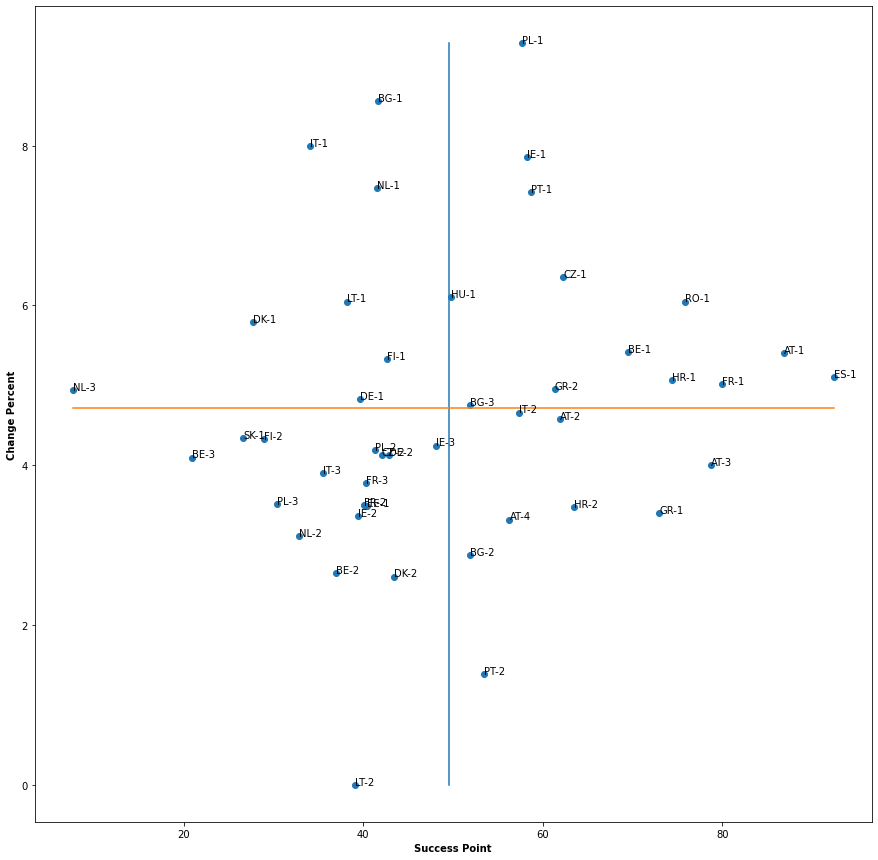

In [14]:
plt.figure(figsize=(15, 15))
y = [lockdown.get_change_percent() for lockdown in lockdowns]
x = [lockdown.fixed_success_point for lockdown in lockdowns]
z = []
lastest_dict = {}
for lockdown in lockdowns:
    if lockdown.country_code in lastest_dict:
        lastest_dict[lockdown.country_code] = lastest_dict[lockdown.country_code] + 1
    else:
        lastest_dict[lockdown.country_code] = 1
    z.append("{}-{}".format(lockdown.country_code, lastest_dict[lockdown.country_code]))

min_y = min(y)
y = [log(v-min_y+1) for v in y]
mean_x = statistics.mean(x)
mean_y = statistics.mean(y)
min_y = min(y)
max_y = max(y)
min_x = min(x)
max_x = max(x)

plt.plot((mean_x, mean_x), (0, max_y))
plt.plot((min_x, max_x), (mean_y, mean_y))
plt.scatter(x, y)
plt.xlabel('Success Point',
               fontweight ='bold')
plt.ylabel('Change Percent',
               fontweight ='bold')
for country_code, success, change in zip(z, x, y):
    plt.annotate(country_code, (success, change))
plt.show()

552.0801375407422
[86.83529585552233, 61.86020743044695, 78.76371878342916, 56.27698677993489, 69.45399335879205, 36.90581053125821, 20.935552811605483, 51.89987813186331, 51.86285913173874, 74.43951333103047, 63.465363514097696, 62.292602219211425, 42.0756766413511, 27.668534961653208, 43.461768850122404, 80.00404240133832, 40.064750440515155, 40.35178745639194, 42.67003700989366, 28.94030549690056, 40.44763452120798, 39.59187330155474, 42.90961177078863, 72.97729109949861, 61.33853902666366, 49.7165329430789, 39.395570110348665, 48.07541443862908, 57.38784375948502, 35.46829268259713, 38.190149329569365, 39.09551061926325, 32.78613508581534, 7.620468643009964, 41.287137497067796, 30.40828861639354, 53.458373701973414, 75.8545140674036, 26.61939006026856, 92.37953135699004] [124.29245283018868, -0.578735384976336, -42.99910595180655, -69.91664823620481, 128.27642121327742, -83.46225986810666, -37.481202724853006, -79.87888482632542, 18.71589241493167, 61.63793103448276, -65.3347107438

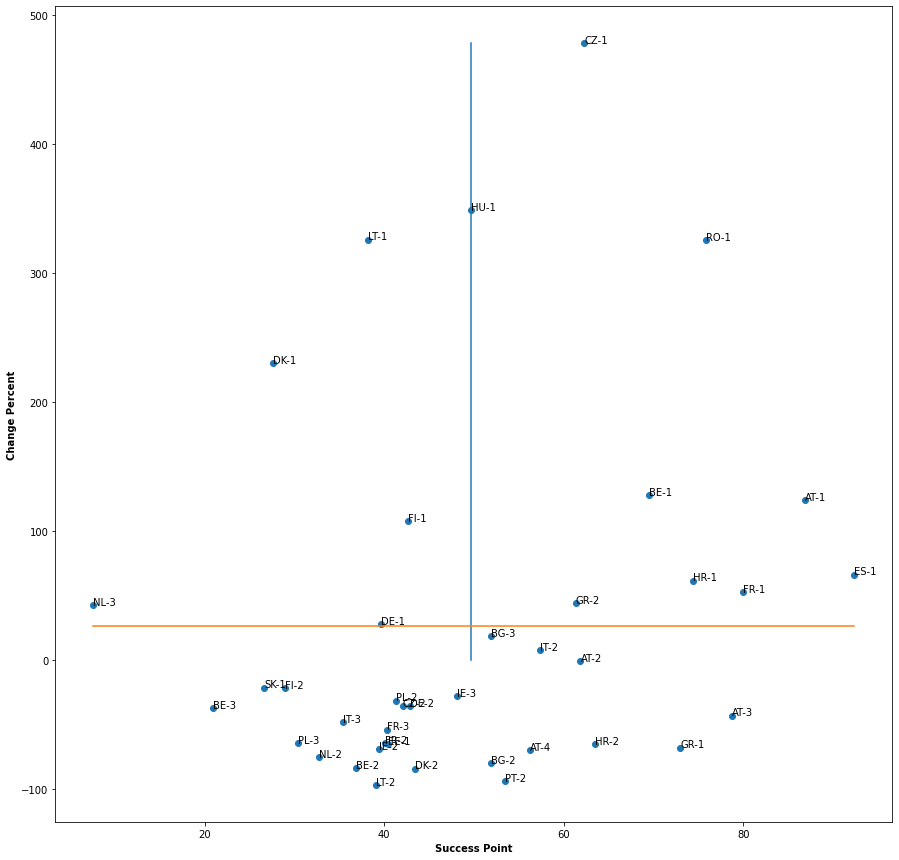

In [21]:
plt.figure(figsize=(15, 15))
y = [lockdown.get_change_percent() for lockdown in lockdowns]
x = [lockdown.fixed_success_point for lockdown in lockdowns]
z = []
lastest_dict = {}
for lockdown in lockdowns:
    if lockdown.country_code in lastest_dict:
        lastest_dict[lockdown.country_code] = lastest_dict[lockdown.country_code] + 1
    else:
        lastest_dict[lockdown.country_code] = 1
    z.append("{}-{}".format(lockdown.country_code, lastest_dict[lockdown.country_code]))


mean_y = statistics.mean(y)
print(mean_y)
x2 = []
y2 = []
z2 = []
for v1, v2, v3 in zip(x, y, z):
    if v2 < mean_y:
        x2.append(v1)
        y2.append(v2)
        z2.append(v3)
mean_x = statistics.mean(x2)
mean_y = statistics.mean(y2)
min_y = min(y2)
max_y = max(y2)
min_x = min(x2)
max_x = max(x2)

plt.plot((mean_x, mean_x), (0, max_y))
plt.plot((min_x, max_x), (mean_y, mean_y))
plt.scatter(x2, y2)
plt.xlabel('Success Point',
               fontweight ='bold')
plt.ylabel('Change Percent',
               fontweight ='bold')
for country_code, success, change in zip(z2, x2, y2):
    plt.annotate(country_code, (success, change))
    print(x2, y2)
plt.show()